# TP2: Críticas cinematográficas
 - 75.06 - Organización de Datos FiUBA - 2023-1c
 - Grupo11: Datatack
 - Integrante: Facundo de la plata - 100558


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score


In [95]:
ds_test = pd.read_csv("./datasets/test.csv")
ds_train = pd.read_csv("./datasets/train.csv")
ds_train_original = ds_train.copy()
ds_test_original = ds_test.copy()

In [55]:
ds_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [69]:
#Genero los conjuntos de train y de test

x_train, x_test, y_train, y_test = train_test_split(ds_train['review_es'],
                                                    ds_train['sentimiento'], 
                                                    test_size=0.3, 
                                                    random_state=25,
                                                    shuffle=True
                                                    ) #semilla)


In [ ]:
ds_test.drop('ID', axis=1,  inplace=True)

In [100]:
x_train

26254    De hecho, en realidad no disfruté de esta pelí...
29815    ... era para que pudiera, en buena conciencia,...
42848    No pude evitar disfrutar de toda la premisa de...
26015    La película de largometraciones CGI se acaba d...
38873    Ok, así que una noche yo y algunos amigos deci...
                               ...                        
35702    En un intento no totalmente exitoso de ser tom...
26767    El caso de la cola de Scorpion es un giallo al...
6618     Atlantis: El imperio perdido es una mejor pelí...
24894    Pensé que esta serie iba a ser otra serie de a...
29828    Vi esta película como una chica muy joven (aho...
Name: review_es, Length: 35000, dtype: object

In [72]:
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
# Indice de frecuencia invertido. Normaliza la cantidad de palabras.
# Le da mayor importancia a las palabras que menos aparecen

X = vectorizer.fit_transform(ds_train['review_es'])
print(X.toarray())

MemoryError: Unable to allocate 65.5 GiB for an array with shape (50000, 175853) and data type float64

In [68]:
y_train.size

35000

Funciones útiles:

In [78]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [83]:
import pickle

def guardar_modelo(model, filename):
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

In [110]:
def guardar_prediccion(y_prediccion, ds_test, name):
    sub = pd.DataFrame(ds_test)
    submition=pd.DataFrame(y_prediccion)
    submition.rename(columns={0: "sentimiento"})
    sub["sentimiento"] = submition
    sub.drop('review_es', axis=1,  inplace=True)
    sub.to_csv(name, index=False)

Bayes Naive

In [75]:
# Build the model
model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model2 = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model using the training data
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

# Predict the categories of the test data
predicted1 = model1.predict(x_test)
predicted2 = model2.predict(x_test)

In [105]:
x_test.head()

13920    Kudos a Fawcett para asumir los roles que, en ...
23439    Si eres fanático de las primeras películas de ...
11851    Me encantaría darle a esta película un 10/10, ...
8278     Los créditos al final leen "Todos dirigidos po...
31258    Este joven cineasta tiene un talento para capt...
Name: review_es, dtype: object

In [106]:
print(predicted1)

['positivo' 'positivo' 'positivo' ... 'negativo' 'positivo' 'positivo']


              precision    recall  f1-score   support

    negativo       0.85      0.86      0.86      7599
    positivo       0.85      0.85      0.85      7401

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



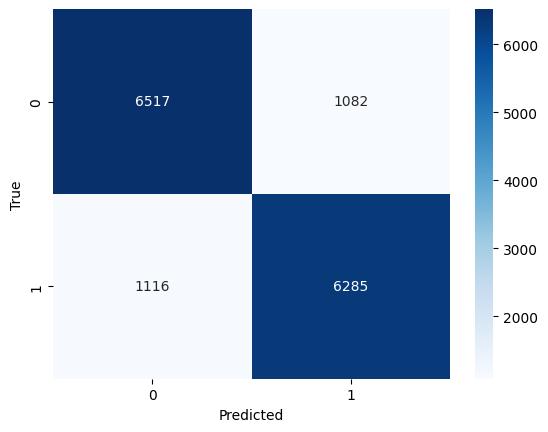

In [79]:

metricas(predicted1,y_test)

In [85]:
guardar_modelo(model1, "./modelos/bayes_naive_model1.sav")

Genero una prediccion

In [107]:
y_prediccion = model1.predict(ds_test['review_es'])

In [108]:
print(y_prediccion)

['negativo' 'negativo' 'negativo' ... 'positivo' 'negativo' 'negativo']


In [111]:
guardar_prediccion(y_prediccion, ds_test, "./predicciones/bayes_naive_1.csv")

              precision    recall  f1-score   support

    negativo       0.82      0.88      0.85      7599
    positivo       0.86      0.80      0.83      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



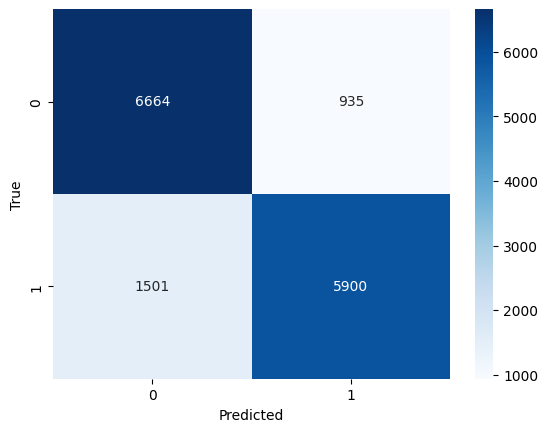

In [80]:
metricas(predicted2,y_test)